In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/Samin1362/MerakiNexus-V2.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'MerakiNexus-V2'...
remote: Enumerating objects: 6412, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 6412 (delta 6), reused 2 (delta 2), pack-reused 6390 (from 4)
Receiving objects: 100% (6412/6412), 1.81 GiB | 28.26 MiB/s, done.
Resolving deltas: 100% (72/72), done.
Updating files: 100% (6226/6226), done.


In [ ]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"  # Update path if needed

# Load datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and initialize counters
class_names = train_dataset.classes
train_image_counts, val_image_counts, test_image_counts = [], [], []

# Count images per class
for class_name in class_names:
    train_count = len(os.listdir(os.path.join(train_dataset.root, class_name)))
    val_count = len(os.listdir(os.path.join(val_dataset.root, class_name)))
    test_count = len(os.listdir(os.path.join(test_dataset.root, class_name)))

    train_image_counts.append(train_count)
    val_image_counts.append(val_count)
    test_image_counts.append(test_count)

# Create vertically stacked subplots
fig, axes = plt.subplots(4, 1, figsize=(16, 30))  # Wider + taller for readability

# Common x-axis style
def style_x_axis(ax):
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90, fontsize=10)
    ax.set_xlabel("Class Name", fontsize=14)
    ax.set_ylabel("Number of Images", fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Training set plot
axes[0].bar(range(len(class_names)), train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
style_x_axis(axes[0])

# Validation set plot
axes[1].bar(range(len(class_names)), val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
style_x_axis(axes[1])

# Test set plot
axes[2].bar(range(len(class_names)), test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
style_x_axis(axes[2])

# Combined view with grouped bars
bar_width = 0.25
x = list(range(len(class_names)))

axes[3].bar([i - bar_width for i in x], train_image_counts, width=bar_width, label='Train', color='skyblue')
axes[3].bar(x, val_image_counts, width=bar_width, label='Validation', color='lightgreen')
axes[3].bar([i + bar_width for i in x], test_image_counts, width=bar_width, label='Test', color='lightcoral')

axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xticks(x)
axes[3].set_xticklabels(class_names, rotation=90, fontsize=10)
axes[3].set_xlabel("Class Name", fontsize=14)
axes[3].set_ylabel("Number of Images", fontsize=14)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Final layout adjustments
plt.tight_layout(pad=4)
plt.show()


# Hyperparameters Tuned:

**learning_rate** = 1e-4 = 0.0001 → works well with Adam.

**dropout = 0.3** -- 30% of units turned off during training to reduce overfitting, because
EfficientNet is a powerful model it may overfit easily.

**batch_size** = 32

**num_epochs** = 25

Train samples: 5168 | Val samples: 512 | Test samples: 511


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5 Training: 100%|██████████| 162/162 [01:30<00:00,  1.80it/s, loss=1.86]


Epoch 1 | Train Loss: 2.5955 | Val Loss: 2.0250 | Val Acc: 45.31%


Epoch 2/5 Training: 100%|██████████| 162/162 [01:23<00:00,  1.94it/s, loss=1.4]


Epoch 2 | Train Loss: 1.6056 | Val Loss: 1.5150 | Val Acc: 54.10%


Epoch 3/5 Training: 100%|██████████| 162/162 [01:27<00:00,  1.84it/s, loss=1.61]


Epoch 3 | Train Loss: 1.1155 | Val Loss: 1.3592 | Val Acc: 56.25%


Epoch 4/5 Training: 100%|██████████| 162/162 [01:23<00:00,  1.93it/s, loss=0.521]


Epoch 4 | Train Loss: 0.8643 | Val Loss: 1.2764 | Val Acc: 60.94%


Epoch 5/5 Training: 100%|██████████| 162/162 [01:18<00:00,  2.06it/s, loss=0.942]


Epoch 5 | Train Loss: 0.6844 | Val Loss: 1.2398 | Val Acc: 63.67%

Total Training Time: 455.45s (7.59min)


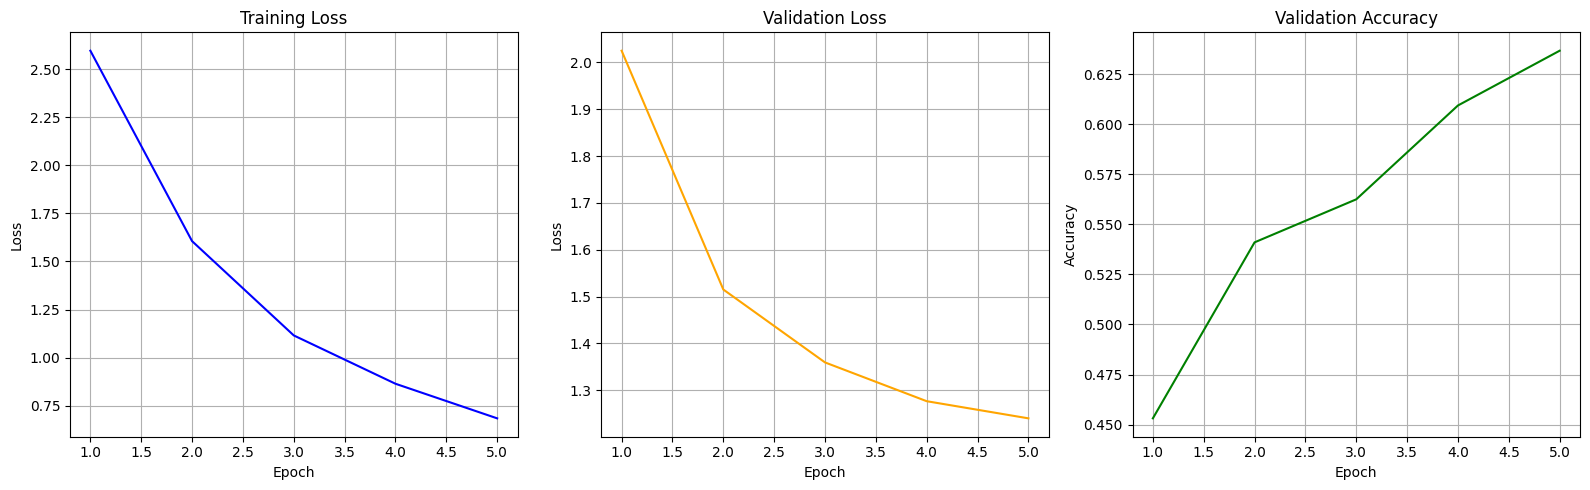


Test Accuracy: 60.47%

Precision, Recall, F1-Score Table:

                        precision  recall  f1-score
abstract_art                0.429   0.240     0.308
abstract_expressionism      0.652   0.600     0.625
amateur                     0.950   0.760     0.844
art_nouveau                 0.538   0.280     0.368
baroque                     0.500   0.917     0.647
chinese_landscape           0.650   0.929     0.765
constructivism              0.438   0.560     0.491
cubism                      0.630   0.680     0.654
expressionism               0.632   0.480     0.545
fauvism                     0.400   0.400     0.400
futurism                    0.474   0.720     0.571
high_renaissance            0.833   0.600     0.698
minimalism                  0.710   0.880     0.786
op_art                      0.645   0.800     0.714
pop_art                     0.455   0.200     0.278
post_impressionism          0.579   0.440     0.500
realism                     0.808   0.913     0.857
rena

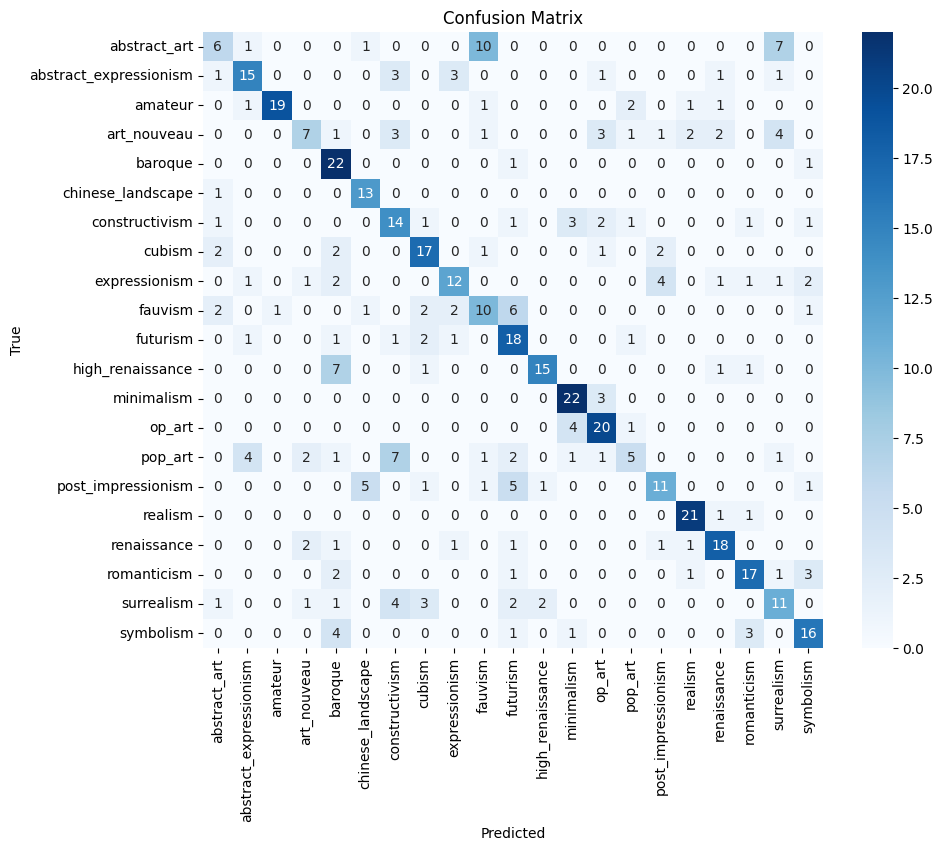

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import pandas as pd
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======== Data Augmentation and Normalization ========
# EfficientNet-b0 input size is 224x224
# Augmentation to increase dataset size & variety (especially if dataset is small)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ======== Dataset and Dataloaders ========
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
val_data = datasets.ImageFolder(root=f"{dataset_path}/val", transform=transform)
test_data = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

# Print dataset sizes (after applying transformations)
print(f"Train samples: {len(train_data)} | Val samples: {len(val_data)} | Test samples: {len(test_data)}")
# Note: Transforms don't change count but alter the images. Data is augmented per batch load.

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# ======== Model Definition ========
class ArtworkClassificationModel(nn.Module):
    def __init__(self, num_classes=11):
        super(ArtworkClassificationModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.3),  # slightly increased dropout for regularization
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

model = ArtworkClassificationModel(num_classes=len(train_data.classes)).to(device)

# ======== Loss Function and Optimizer ========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Learning rate = 0.0001 (tuned manually)

# ======== Training Loop ========
num_epochs = 5  # Can tune this between 15-30 based on overfitting/underfitting

train_losses = []
val_losses = []
val_accuracies = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            tepoch.set_postfix(loss=loss.item())

    train_loss_epoch = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss_epoch)

    # ======== Validation ========
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss_epoch = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f} | Val Acc: {val_accuracy*100:.2f}%")

total_time = time.time() - start_time
print(f"\nTotal Training Time: {total_time:.2f}s ({total_time/60:.2f}min)")

# ======== Metric Visualization ========
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss", color='orange')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), val_accuracies, label="Val Accuracy", color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# ======== Evaluation on Test Set ========
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# ======== Classification Report & Confusion Matrix ========
report = classification_report(all_labels, all_preds, target_names=train_data.classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print("\nPrecision, Recall, F1-Score Table:\n")
print(df_report[['precision', 'recall', 'f1-score']].round(3))

# ======== Confusion Matrix ========
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [7]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# ======== Evaluation on Test Set ========
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ======== Overall Test Accuracy ========
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")

# ======== Precision, Recall, F1-Score ========
report = classification_report(
    all_labels,
    all_preds,
    target_names=test_data.classes,
    digits=3,
    output_dict=True  # so we can convert to a table
)

import pandas as pd
df_metrics = pd.DataFrame(report).transpose()
print("\n📊 Classification Report (per class):\n")
print(df_metrics[['precision', 'recall', 'f1-score']].round(3))

# Optional: Save as CSV
# df_metrics.to_csv("classification_metrics_test.csv")




✅ Test Accuracy: 60.86%

📊 Classification Report (per class):

                        precision  recall  f1-score
abstract_art                0.538   0.280     0.368
abstract_expressionism      0.636   0.560     0.596
amateur                     0.895   0.680     0.773
art_nouveau                 0.550   0.440     0.489
baroque                     0.524   0.917     0.667
chinese_landscape           0.667   1.000     0.800
constructivism              0.406   0.520     0.456
cubism                      0.739   0.680     0.708
expressionism               0.619   0.520     0.565
fauvism                     0.370   0.400     0.385
futurism                    0.486   0.680     0.567
high_renaissance            0.750   0.600     0.667
minimalism                  0.690   0.800     0.741
op_art                      0.606   0.800     0.690
pop_art                     0.500   0.240     0.324
post_impressionism          0.550   0.440     0.489
realism                     0.783   0.783     0.783
